### CONFIGURACAO AMBIENTE

In [1]:
# Importar as bibliotecas necessárias
import pandas as pd
import numpy as np
import os
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sqlalchemy import create_engine

# Configurações do banco de dados
DB_NAME = "vitivinicultura_db"
DB_USER = "postgres"
DB_PASSWORD = "102030"
DB_HOST = "localhost"
DB_PORT = "5432"

# Criar o engine de conexão usando SQLAlchemy
connection_string = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(connection_string)

# Criar uma conexão a partir do engine
connection = engine.raw_connection()


### DATA LOAD

In [2]:
# Carregar os dados da tabela de exportação
query = "SELECT * FROM exportacao;"
df_exportacao = pd.read_sql(query, con=connection)

# Fechar a conexão
connection.close()

# Visualizar os primeiros registros dos dados carregados
df_exportacao.head()


/tmp/ipykernel_385492/2683005586.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_exportacao = pd.read_sql(query, con=connection)


,id,ano,pais,quantidade_litros,valor_usd,data_insercao
0,1,2023,Afeganistão,NaN,NaN,2025-03-30 18:27:41.917881
1,2,2023,África do Sul,117.0,698.0,2025-03-30 18:27:41.917881
2,3,2023,"Alemanha, República Democrática",4806.0,31853.0,2025-03-30 18:27:41.917881
3,4,2023,Angola,NaN,NaN,2025-03-30 18:27:41.917881
4,5,2023,Anguilla,NaN,NaN,2025-03-30 18:27:41.917881


### DATA PREPARATION

In [3]:
# Substituir "-" por NaN nas colunas 'quantidade_litros' e 'valor_usd'
df_exportacao['quantidade_litros'] = pd.to_numeric(df_exportacao['quantidade_litros'], errors='coerce')
df_exportacao['valor_usd'] = pd.to_numeric(df_exportacao['valor_usd'], errors='coerce')

# Remover linhas com valores ausentes (NaN) em 'quantidade_litros' ou 'valor_usd'
df_clean = df_exportacao.dropna(subset=['quantidade_litros', 'valor_usd'])

# Verificar se há mais dados ausentes após limpeza
df_clean.isnull().sum()

id                   0
ano                  0
pais                 0
quantidade_litros    0
valor_usd            0
data_insercao        0
dtype: int64

Correlação entre quantidade_litros e valor_usd: 0.97


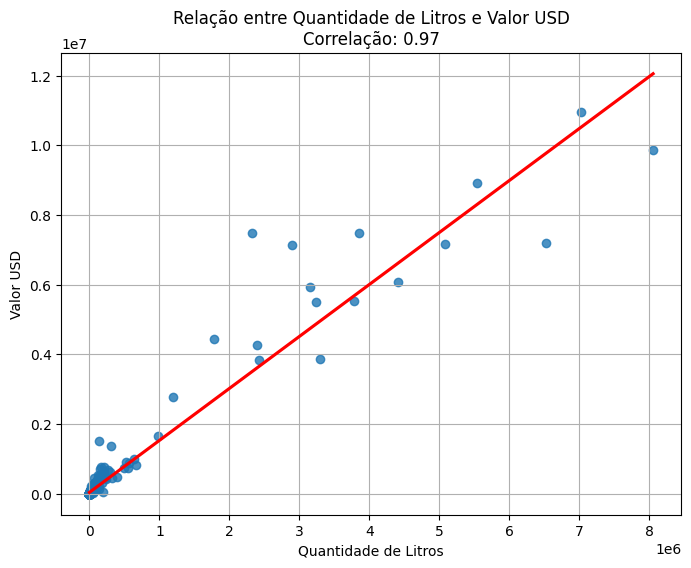

In [4]:
# Calcular a correlação
correlacao = df_clean[['quantidade_litros', 'valor_usd']].corr().iloc[0, 1]
print(f"Correlação entre quantidade_litros e valor_usd: {correlacao:.2f}")

# Scatter plot com linha de tendência
plt.figure(figsize=(8, 6))
sns.regplot(data=df_clean, x='quantidade_litros', y='valor_usd', ci=None, line_kws={"color": "red"})
plt.title(f"Relação entre Quantidade de Litros e Valor USD\nCorrelação: {correlacao:.2f}")
plt.xlabel("Quantidade de Litros")
plt.ylabel("Valor USD")
plt.grid()
plt.show()

#### GERAR DADOS SINTETICOS E ADICIONAR RUIDOS

In [ ]:
# Gerar dados sintéticos a partir do dataframe original
def gerar_dados_sinteticos(df_original, num_novos_dados):
    # Inicializar uma lista para armazenar os novos dados
    dados_sinteticos = []

    for _ in range(num_novos_dados):
        # Seleciona um registro aleatório do dataframe original
        sample = df_original.sample(n=1, random_state=np.random.randint(0, 100000))

        # Adiciona ruído nas variáveis 'quantidade_litros' e 'valor_usd'
        ruido_quantidade = np.random.normal(loc=0, scale=sample['quantidade_litros'].values[0] * 0.1)
        ruido_valor = np.random.normal(loc=0, scale=sample['valor_usd'].values[0] * 0.1)

        # Cria uma nova amostra com o ruído
        novo_dado = {
            'ano': sample['ano'].values[0],
            'pais': sample['pais'].values[0],
            'quantidade_litros': sample['quantidade_litros'].values[0] + ruido_quantidade,
            'valor_usd': sample['valor_usd'].values[0] + ruido_valor
        }

        # Adiciona a nova amostra à lista de dados sintéticos
        dados_sinteticos.append(novo_dado)

    # Converter a lista de dados sintéticos para um DataFrame
    df_sintetico = pd.DataFrame(dados_sinteticos)

    return df_sintetico

# Gerar 1000 novos registros sintéticos
df_novos_dados = gerar_dados_sinteticos(df_clean, 1000)

# Concatenar os dados reais com os dados sintéticos
df_clean = pd.concat([df_clean, df_novos_dados], ignore_index=True)

# Verificar o DataFrame final
df_clean.head()


,id,ano,pais,quantidade_litros,valor_usd,data_insercao
0,2.0,2023,África do Sul,117.0,698.0,2025-03-30 18:27:41.917881
1,3.0,2023,"Alemanha, República Democrática",4806.0,31853.0,2025-03-30 18:27:41.917881
2,6.0,2023,Antígua e Barbuda,383.0,1848.0,2025-03-30 18:27:41.917881
3,8.0,2023,Arábia Saudita,124.0,142.0,2025-03-30 18:27:41.917881
4,9.0,2023,Argentina,4545.0,36133.0,2025-03-30 18:27:41.917881


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 565 non-null    float64       
 1   ano                1565 non-null   int64         
 2   pais               1565 non-null   object        
 3   quantidade_litros  1565 non-null   float64       
 4   valor_usd          1565 non-null   float64       
 5   data_insercao      565 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 73.5+ KB


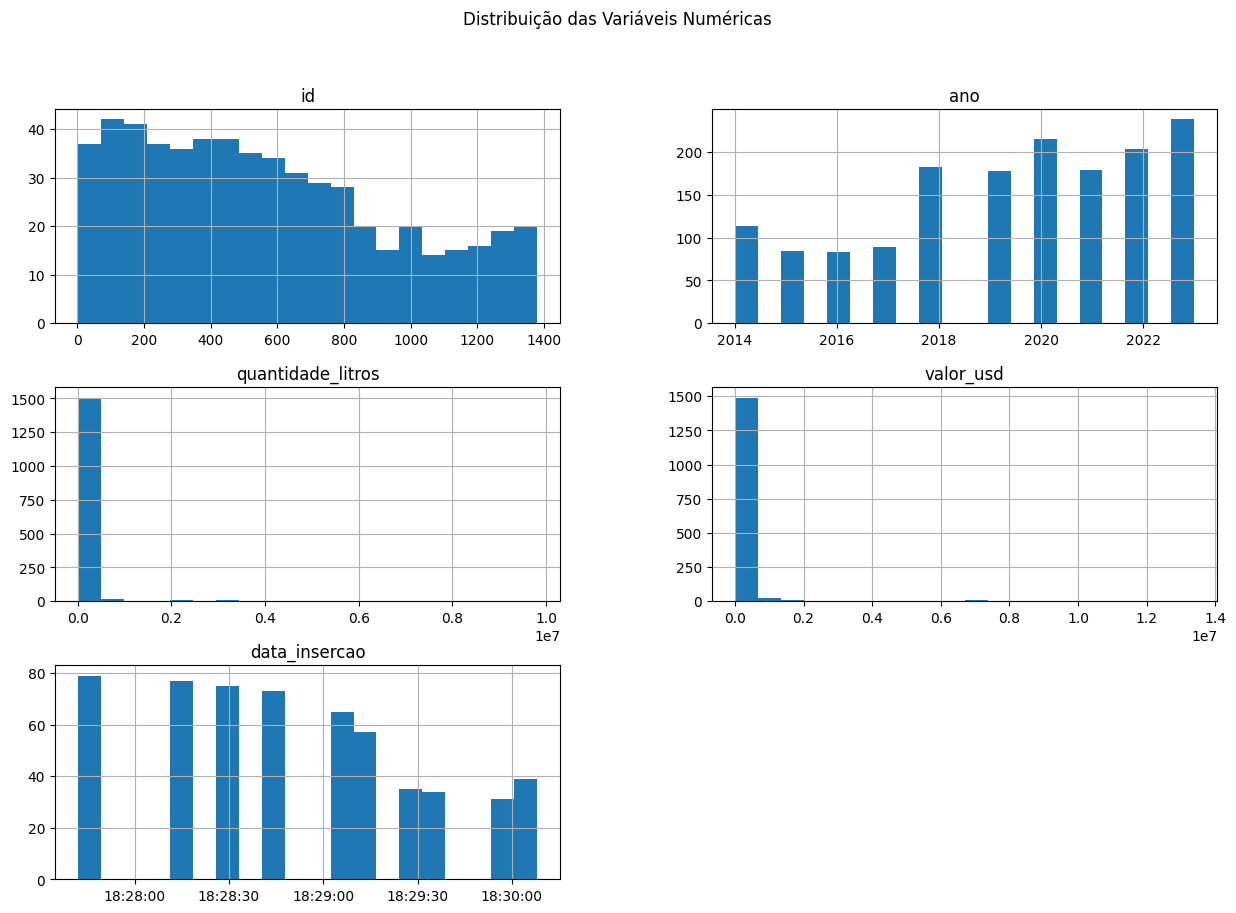

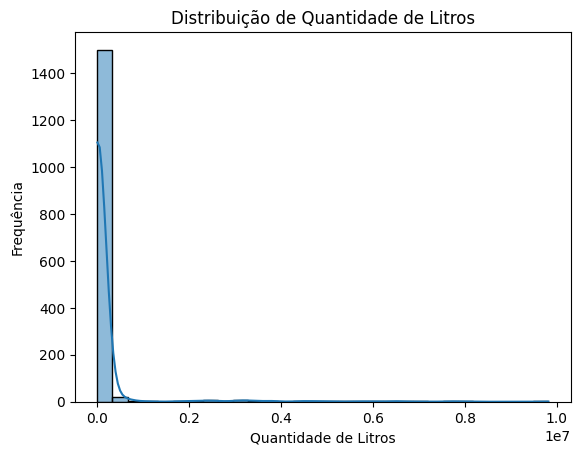

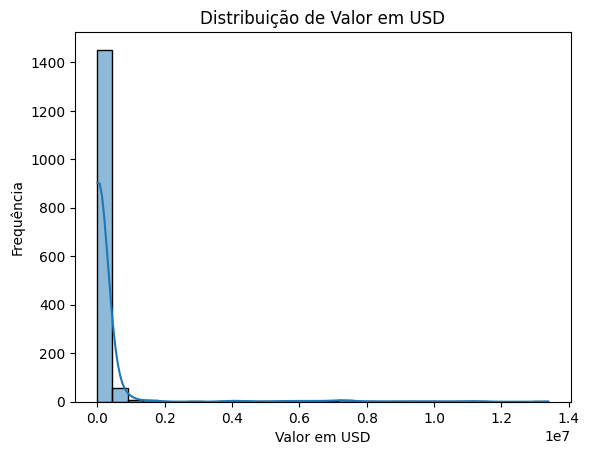

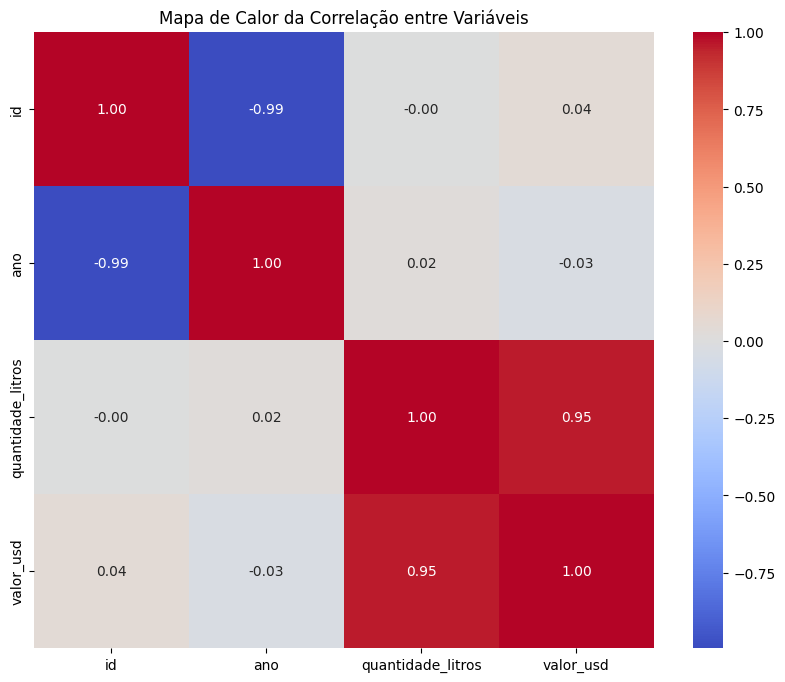

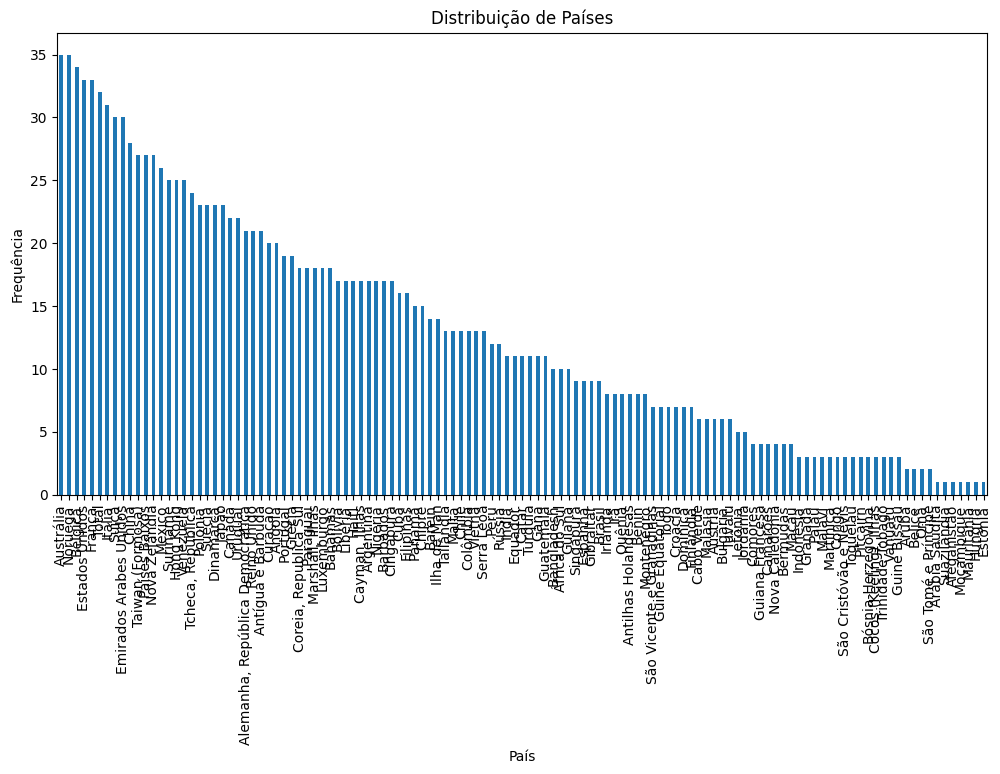

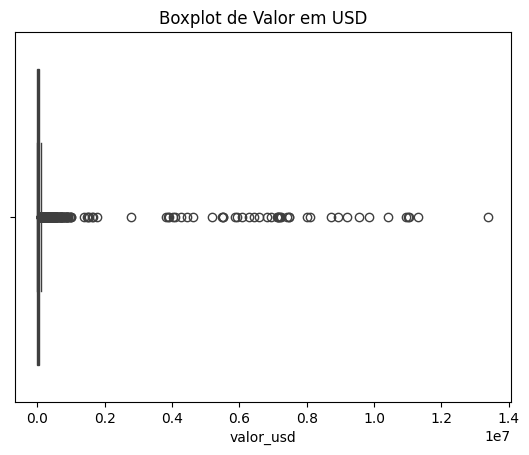

In [20]:
df_clean.head()
# Informações gerais sobre o DataFrame
df_clean.info()

# Estatísticas descritivas
df_clean.describe()

# Verificar a quantidade de valores nulos em cada coluna
df_clean.isnull().sum()



# Histograma para cada coluna numérica
df_clean.hist(bins=20, figsize=(15, 10))
plt.suptitle("Distribuição das Variáveis Numéricas")
plt.show()


# Exemplo: Distribuição da coluna 'quantidade_litros'
sns.histplot(df_clean['quantidade_litros'], kde=True, bins=30)
plt.title("Distribuição de Quantidade de Litros")
plt.xlabel("Quantidade de Litros")
plt.ylabel("Frequência")
plt.show()


# Exemplo: Distribuição da coluna 'valor_usd'
sns.histplot(df_clean['valor_usd'], kde=True, bins=30)
plt.title("Distribuição de Valor em USD")
plt.xlabel("Valor em USD")
plt.ylabel("Frequência")
plt.show()


# Matriz de correlação
df_numeric = df_clean.select_dtypes(include=['number'])
# Calcular a matriz de correlação
correlation_matrix = df_numeric.corr()

# Mapa de calor para visualizar a correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Mapa de Calor da Correlação entre Variáveis")
plt.show()

# Exemplo: Contagem de valores únicos na coluna 'pais'
df_clean['pais'].value_counts().plot(kind='bar', figsize=(12, 6))
plt.title("Distribuição de Países")
plt.xlabel("País")
plt.ylabel("Frequência")
plt.show()

# Exemplo: Boxplot para a coluna 'valor_usd'
sns.boxplot(x=df_clean['valor_usd'])
plt.title("Boxplot de Valor em USD")
plt.show()

Correlação entre quantidade_litros e valor_usd: 0.95


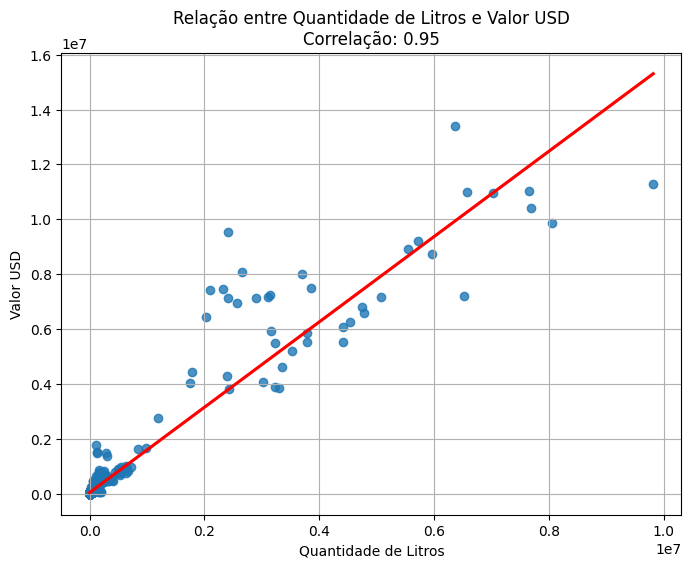

In [6]:
# Calcular a correlação
correlacao = df_clean[['quantidade_litros', 'valor_usd']].corr().iloc[0, 1]
print(f"Correlação entre quantidade_litros e valor_usd: {correlacao:.2f}")

# Scatter plot com linha de tendência
plt.figure(figsize=(8, 6))
sns.regplot(data=df_clean, x='quantidade_litros', y='valor_usd', ci=None, line_kws={"color": "red"})
plt.title(f"Relação entre Quantidade de Litros e Valor USD\nCorrelação: {correlacao:.2f}")
plt.xlabel("Quantidade de Litros")
plt.ylabel("Valor USD")
plt.grid()
plt.show()

In [7]:
# Codificar os países usando OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Codificar a coluna 'pais'
pais_encoded = encoder.fit_transform(df_clean[['pais']])

# Criar um DataFrame com as variáveis codificadas
pais_encoded_df = pd.DataFrame(pais_encoded, columns=encoder.get_feature_names_out(['pais']))

# Concatenar as variáveis codificadas com os dados numéricos
df_encoded = pd.concat([df_clean[['ano', 'quantidade_litros', 'valor_usd']], pais_encoded_df], axis=1)

# Exibir as primeiras linhas do DataFrame codificado
df_encoded.head()

,ano,quantidade_litros,valor_usd,pais_Afeganistão,"pais_Alemanha, República Democrática",pais_Angola,pais_Antilhas Holandesas,pais_Antígua e Barbuda,pais_Argentina,pais_Aruba,...,pais_Total,pais_Trinidade Tobago,pais_Turquia,pais_Tuvalu,pais_Uruguai,pais_Vanuatu,pais_Venezuela,pais_Vietnã,pais_África do Sul,pais_Áustria
0,2023,117.0,698.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2023,4806.0,31853.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023,383.0,1848.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023,124.0,142.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023,4545.0,36133.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
print(df_encoded.columns)

Index(['ano', 'quantidade_litros', 'valor_usd', 'pais_Afeganistão',
       'pais_Alemanha, República Democrática', 'pais_Angola',
       'pais_Antilhas Holandesas', 'pais_Antígua e Barbuda', 'pais_Argentina',
       'pais_Aruba',
       ...
       'pais_Total', 'pais_Trinidade Tobago', 'pais_Turquia', 'pais_Tuvalu',
       'pais_Uruguai', 'pais_Vanuatu', 'pais_Venezuela', 'pais_Vietnã',
       'pais_África do Sul', 'pais_Áustria'],
      dtype='object', length=124)


In [9]:
# Definir as variáveis de entrada (X) e as variáveis de saída (y)
X = df_encoded.drop(columns=['quantidade_litros', 'valor_usd'])  # Remover as colunas de saída
y = df_encoded[['quantidade_litros', 'valor_usd']]  # Colunas de saída

#y = df_encoded['valor_usd'] # Colunas de saída


In [10]:

# Dividir os dados em conjunto de treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Preencher valores NaN com a média das colunas
X_train = X_train.fillna(X_train.mean())
y_train = y_train.fillna(y_train.mean())
X_test = X_test.fillna(X_test.mean())
y_test = y_test.fillna(y_test.mean())


# Exibir as dimensões dos conjuntos de treino e teste
print(f"Dimensões do conjunto de treino X: {X_train.shape}")
print(f"Dimensões do conjunto de teste X: {X_test.shape}")
print(f"Dimensões do conjunto de treino y: {y_train.shape}")
print(f"Dimensões do conjunto de teste y: {y_test.shape}")


Dimensões do conjunto de treino X: (1252, 122)
Dimensões do conjunto de teste X: (313, 122)
Dimensões do conjunto de treino y: (1252, 2)
Dimensões do conjunto de teste y: (313, 2)


## MODEL TRAINING

#### TRAINING (LINEAR REGRESSION)

In [11]:
# Criar o modelo de Regressão Linear
model = LinearRegression()

# Treinar o modelo com os dados de treino
model.fit(X_train, y_train)

# Exibir os coeficientes do modelo treinado
print(f"Coeficientes do modelo: {model.coef_}")

Coeficientes do modelo: [[ 2.72117016e+04 -9.81714562e+04 -2.05029191e+04 -2.82462122e+03
   5.92092453e+04 -9.61112522e+04 -4.78210424e+04  9.27659963e+04
  -1.52481859e+05 -1.82305116e+04 -8.46256445e+04 -9.47775507e+04
  -1.13608193e+05 -8.86952494e+04 -4.37500531e+04 -6.54396845e+03
  -1.52590467e+05 -2.30139256e+04 -1.19476401e+05 -5.73039673e+04
  -1.75284886e+04 -7.09292982e+04 -5.73493138e+04 -7.09707547e+04
  -1.09804525e+04 -9.48036321e+04 -8.53279906e+04 -9.18186277e+04
   6.81726129e+04 -7.43591359e+04  3.26478627e+04 -1.25368708e+05
  -7.46694417e+04 -7.09615741e+04 -1.36063226e+05 -4.52983567e+04
  -8.45536264e+04  2.71418026e+04 -5.38874810e+04 -6.05159926e+04
  -1.08858505e+05 -4.87252755e+03 -9.43690244e+04 -6.09284372e+04
   1.92712844e+05  3.87760516e+04 -9.91938221e+04 -7.30888055e+02
  -1.57961796e+04 -2.96705375e+04 -6.02710820e+04 -1.19948555e+05
  -8.82893801e+04 -1.11131526e+05 -7.67649421e+04 -1.04908983e+05
   1.07155557e+04 -5.98714352e+02  2.90724416e+05 -9

#### EVALUATE MODEL

In [12]:
# Fazer previsões com os dados de teste
y_pred = model.predict(X_test)

# Calcular o erro quadrático médio (MSE)
mse = mean_squared_error(y_test, y_pred)

# Exibir o MSE
print(f"Erro Quadrático Médio (MSE): {mse}")

Erro Quadrático Médio (MSE): 182013420931.94067


### PREDICT

In [13]:
# Exemplo de previsão para o ano de 2024 e país "Brasil"
novo_ano = 2024
novo_pais = 'Brasil'

# Criar um DataFrame com o ano e a codificação do país
novo_pais_encoded = encoder.transform([[novo_pais]])
entrada = pd.DataFrame([list([novo_ano]) + list(novo_pais_encoded[0])], columns=X.columns)

# Fazer a previsão de quantidade de litros e valor em USD para o novo país e ano
quantidade_prevista, valor_previsto = model.predict(entrada)[0]

# Exibir os resultados da previsão
print(f"Previsão para o {novo_pais} em {novo_ano}:")
print(f"Quantidade de Litros: {quantidade_prevista}")
print(f"Valor em USD: {valor_previsto}")


Previsão para o Brasil em 2024:
Quantidade de Litros: 60341.15972653031
Valor em USD: 41395.05096974969


/home/alberone/projects/fiap/ml-engineering/ml-tech-fiap-vitivinicultura-api/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


### SAVE MODEL

In [14]:

# Obter o diretório atual do notebook
notebook_dir = os.getcwd()


# Subir dois níveis na hierarquia de diretórios
parent_dir_two_levels_up = os.path.abspath(os.path.join(notebook_dir, os.pardir, os.pardir))


print(f"{parent_dir_two_levels_up}")

# Caminho relativo à raiz do projeto
save_dir = os.path.join(parent_dir_two_levels_up, 'ml-model', 'production')

# Certifique-se de que o diretório existe
os.makedirs(save_dir, exist_ok=True)

# Caminhos completos para os arquivos
model_path = os.path.join(save_dir, 'modelo_exportacao.pkl')
encoder_path = os.path.join(save_dir, 'encoder_exportacao.pkl')

# Salvar o modelo treinado e o encoder
import joblib
joblib.dump(model, model_path)
joblib.dump(encoder, encoder_path)

print(f"Modelo salvo em: {model_path}")
print(f"Encoder salvo em: {encoder_path}")

/home/alberone/projects/fiap/ml-engineering/ml-tech-fiap-vitivinicultura-api
Modelo salvo em: /home/alberone/projects/fiap/ml-engineering/ml-tech-fiap-vitivinicultura-api/ml-model/production/modelo_exportacao.pkl
Encoder salvo em: /home/alberone/projects/fiap/ml-engineering/ml-tech-fiap-vitivinicultura-api/ml-model/production/encoder_exportacao.pkl
